# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Project-Overview" data-toc-modified-id="Project-Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project Overview</a></div><div class="lev1 toc-item"><a href="#Part-1---Scraping-The-Federalist-Papers" data-toc-modified-id="Part-1---Scraping-The-Federalist-Papers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part 1 - Scraping The Federalist Papers</a></div><div class="lev1 toc-item"><a href="#Part-2---Read-in-the-Data" data-toc-modified-id="Part-2---Read-in-the-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part 2 - Read in the Data</a></div><div class="lev1 toc-item"><a href="#Part-3---Creating-data-frame-of-token-frequencies" data-toc-modified-id="Part-3---Creating-data-frame-of-token-frequencies-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part 3 - Creating data frame of token frequencies</a></div><div class="lev1 toc-item"><a href="#Dimensionality-Reduction-with-PCA-and-LDA" data-toc-modified-id="Dimensionality-Reduction-with-PCA-and-LDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Dimensionality Reduction with PCA and LDA</a></div><div class="lev2 toc-item"><a href="#PCA-Example" data-toc-modified-id="PCA-Example-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>PCA Example</a></div><div class="lev2 toc-item"><a href="#PCA-+-LDA-Pipeline" data-toc-modified-id="PCA-+-LDA-Pipeline-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>PCA + LDA Pipeline</a></div><div class="lev1 toc-item"><a href="#Tune-PCA-Components" data-toc-modified-id="Tune-PCA-Components-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tune PCA Components</a></div>

# Project

As an example project, we're going to try to resolve the authorship of the Federalist Papers.

## Part 1 - Scraping The Federalist Papers ###

First we want to retrieve the contents of all the [federalist papers](https://avalon.law.yale.edu/subject_menus/fed.asp) from the Yale law school website. We can do this using the `requests` package to retrieve the HTML for each paper's web page, then use the `bs4` package to parse that HTML, and finally save the actual text contents of each paper to our data folder. We have a stand-alone python script `scrape_federalist_papers.py` which does this; **as an exercise you can try writing such a script yourself.**

Jupyter provides the **`%run` "magic" command** for executing code in external python scripts, where all the script variables become available within your notebook namespace. We'll run our scraping script now, which will write the federalist papers as individual text files in the `federalist_papers` folder. 

**I've already provided you with the resulting files, so you don't actually need to execute the following cell during the workshop. (It takes a while to run.)**

In [18]:
%run scrape_federalist_papers.py

Scraping federalist papers 1 through 85...
1
2
Scraping author names from webpage table...


## Part 2 - Read in the Data

In [1]:
from pathlib import Path
import pandas as pd
import os

In [2]:
# Set the data folder where the papers are saved (papers are identified by integers)
datapath = Path("federalist_papers")

In [3]:
# Read in the list of authors we scraped from the table on the website
authors = pd.read_csv(datapath / "authors.csv", 
                          squeeze=True,  # squeeze will read in as a Series rather than Dataframe
                          header=None)
author_list = authors.tolist()
author_list[:3]

['Hamilton', 'Jay', 'Jay']

In [4]:
# Get a list of all the paper filepaths
docnames = [datapath / f for f in os.listdir(datapath) if f[-4:]==".txt"]
docnames.sort()  # sort the list IN PLACE alphabetically (i.e. numerically in this case)
docnames[:3]

[WindowsPath('federalist_papers/01.txt'),
 WindowsPath('federalist_papers/02.txt'),
 WindowsPath('federalist_papers/03.txt')]

In [5]:
# Each author will have all his papers merged into a single string
hamilton = ""
madison = ""
jay = ""

N = len(docnames)
for i in range(N):
    with open(docnames[i], 'r') as f:
        if author_list[i] == "Hamilton":
            hamilton += f.read() + " "
        elif author_list[i] == "Madison":
            madison += f.read() + " "
        elif author_list[i] == "Jay":
            jay += f.read() + " "
        else:
            # discard papers with mixed authorship e.g. "Hamilton and Madison"
            pass

In [6]:
len(hamilton), len(madison), len(jay)

(687062, 232117, 50516)

In [7]:
hamilton[:60]

'To the People of the State of New York:  \nAFTER an unequivoc'

## Part 3 - Creating data frame of token frequencies ###

In [8]:
import nltk
import re

In [9]:
nltk.download('punkt')  # download a pre-trained tokenizer that nltk will use for tokenizng the doc text

# Tokenize each document (split it into words) and represent each doc as a word frequency vector
N = len(docnames)
tables = [None]*N
for i in range(N):
    with open(docnames[i], 'r') as f:
        doc = f.read()
        doc = doc.replace("To the People of the State of New York:", "")
        doc = doc.replace("PUBLIUS", "")
        doc = doc.replace("Ã¥", "")
        doc = re.sub("[0-9]+", "", doc)
        doc = doc.lower()
        tokens = nltk.tokenize.word_tokenize(doc)  # tokenize the doc into a list of words
        tables[i] = nltk.FreqDist(tokens)  # vectorize the list of words into a vector of word frequencies

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12565\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# We now have a list where each element is a word count vector for a single document
tables[:3]

[FreqDist({'the': 131, ',': 105, 'of': 104, 'to': 71, '.': 49, 'and': 40, 'be': 34, 'that': 28, 'in': 27, 'a': 25, ...}),
 FreqDist({',': 122, 'the': 105, 'and': 83, 'of': 81, 'to': 52, 'that': 44, '.': 41, 'it': 38, 'in': 34, 'a': 30, ...}),
 FreqDist({',': 121, 'the': 91, 'and': 61, 'of': 60, 'to': 55, '.': 37, 'or': 32, 'be': 31, 'in': 25, 'as': 24, ...})]

In [11]:
# Cast the list of word count vectors into a dataframe
# Each row corresponds to a single document
# The columns will be the complete word set across all the docs
# (and we will get NaN for any word that was not present in a particular document)
df = pd.DataFrame(tables)
df.head(3)

,after,an,unequivocal,experience,of,the,inefficiency,subsisting,federal,government,...,rare,abate,dint,demagogue,prodigy,completion,trembling,recommence,hume,essays
0,2.0,11,1.0,1.0,104,131,1.0,1.0,1.0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,NaN,2.0,81,105,NaN,NaN,2.0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3,NaN,1.0,60,91,NaN,NaN,2.0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Fill in zeros for the NaNs
df.fillna(0, inplace=True)

# Divide rows by totals to normalize the word count within a document into a word frequency
for i in range(N):
    s = sum(df.iloc[i])
    df.iloc[i] = [n/s for n in df.iloc[i]]

df.head(3)

,after,an,unequivocal,experience,of,the,inefficiency,subsisting,federal,government,...,rare,abate,dint,demagogue,prodigy,completion,trembling,recommence,hume,essays
0,0.001129,0.006208,0.000564,0.000564,0.058691,0.073928,0.000564,0.000564,0.000564,0.005079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000542,0.000542,0.000000,0.001084,0.043902,0.056911,0.000000,0.000000,0.001084,0.004878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.001846,0.000000,0.000615,0.036923,0.056000,0.000000,0.000000,0.001231,0.009846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Write as csv
df.to_csv(datapath / "federalist.csv", index=False)

# Dimensionality Reduction with PCA and LDA

The `sklearn` documentation for the [`PCA`](https://scikit-learn.org/stable/modules/decomposition.html#pca) and [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) classes is helpful for understanding broadly what these two algorithms do. 

We use PCA to find the directions/vectors in the input data space that spread the data out most effectively - directions along which the data does not have much variance i.e. all points have similar values can be discarded without much loss of information. PCA is blind to data labels.

LDA is also used for dimensinoality reduction of the data but it is not blind to labels - it will identify the directions/vectors in the input data which most effectively spread out the *classes*.

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

In [15]:
# Read in the list of authors we scraped from the table on the website
x = pd.read_csv(datapath / "federalist.csv")
x.head(2)

,after,an,unequivocal,experience,of,the,inefficiency,subsisting,federal,government,...,rare,abate,dint,demagogue,prodigy,completion,trembling,recommence,hume,essays
0,0.001129,0.006208,0.000564,0.000564,0.058691,0.073928,0.000564,0.000564,0.000564,0.005079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000542,0.000542,0.000000,0.001084,0.043902,0.056911,0.000000,0.000000,0.001084,0.004878,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
authors = np.array(authors)
unknown_docs = authors == "Hamilton or Madison"
mixedauthor_docs = authors == "Hamilton and Madison"

singleauthors = [author for author in authors if (author != "Hamilton or Madison") & (author != "Hamilton and Madison")]
singleauthor_docs = x[(authors != "Hamilton or Madison") & (authors != "Hamilton and Madison")]

In [17]:
author_codes = pd.Categorical(singleauthors)  # Useful to cast the list of authors to a list of integer categories

## PCA Example

In [18]:
# PCA can be used for unsupervised dimensionality reduction on unlabeled data
# Note, sklearn PCA will center but not scale each feature prior to SVD

# Instantiate PCA model with how many principal components to return
pca = PCA(n_components=2)
# Fitting the model means identifying the principal components from the input data, these are stored in the model
# Transforming with the fitted model means casting any new data into the principal component basis
x_pca = pca.fit_transform(singleauthor_docs.values)  # (the fit_transform method does both at the same time)

In [19]:
# Get the results as a dataframe for plotting
pca_results = pd.DataFrame(x_pca, columns=["pc1", "pc2"])
pca_results["author"] = singleauthors

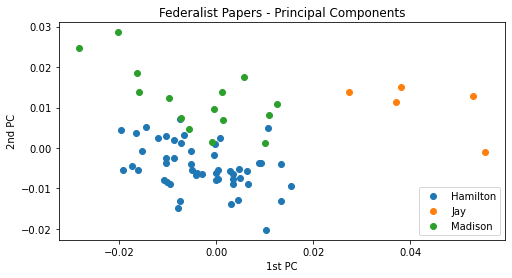

In [20]:
# Plot the data points in the principal components basis, colored by author
fig, ax = plt.subplots(figsize=[8, 4])
for author, grp in pca_results.groupby(["author"]):
    ax.scatter(grp["pc1"], grp["pc2"], label=author)
ax.set_title("Federalist Papers - Principal Components")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.legend(loc="lower right")

## PCA + LDA Pipeline

In [21]:
# PCA followed by LDA, wrapped together in a sklearn pipeline
pl_steps = [("pca", PCA(n_components=30)),
     ("lda", LDA(n_components=2))]  # max number of components for LDA is (num_classes - 1)... also 2D viz is useful
pl = Pipeline(pl_steps)

In [22]:
# Fit/transform the pipeline with the known authorship documents
x_lda = pl.fit_transform(singleauthor_docs.values, y=singleauthors)

# Get the results as a dataframe for plotting
lda_results = pd.DataFrame(x_lda, columns=["pc1", "pc2"])
lda_results["author"] = singleauthors

In [23]:
# Apply the fitted transformation to the unknown and mixed author papers
# (the PCA and LDA models will apply the same principal components / transformations determined by the fit)
x_lda_unknown = pl.transform(x.loc[unknown_docs, :].values)
x_lda_mixed = pl.transform(x.loc[mixedauthor_docs, :].values)

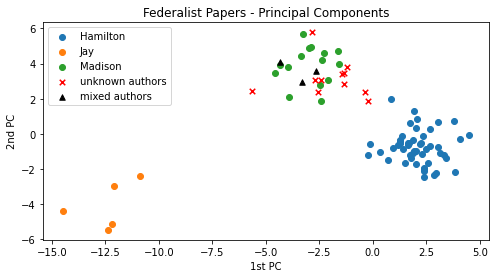

In [24]:
# Plot the data points in the principal components basis, colored by author
fig, ax = plt.subplots(figsize=[8, 4])
for author, grp in lda_results.groupby(["author"]):
    ax.scatter(grp["pc1"], grp["pc2"], label=author)
ax.scatter(x_lda_unknown[:, 0], x_lda_unknown[:, 1], marker="x", s=30, color="red", label="unknown authors")
ax.scatter(x_lda_mixed[:, 0], x_lda_mixed[:, 1], marker="^", s=30, color="black", label="mixed authors")
ax.set_title("Federalist Papers - Principal Components")
ax.set_xlabel("1st PC")
ax.set_ylabel("2nd PC")
ax.legend(loc="upper left")

# Tune PCA Components

In [25]:
from sklearn.model_selection import GridSearchCV

In [27]:
# Define the set of values for PCA n_components that will be tried
parameters = {"pca__n_components": np.arange(10, 40, 3)}

# Instantiate the grid search for our pipeline and parameters
# (will do k-folds CV)
# (the max number of PCA components is limited by number of training points, so don't want 2- or 3-fold)
cv = GridSearchCV(estimator=pl,
                  param_grid=parameters,
                  cv=3,
                  scoring="accuracy",
                  return_train_score=True
                 )
cv.fit(X=singleauthor_docs.values, 
       y=singleauthors)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(n_components=30)),
                                       ('lda',
                                        LinearDiscriminantAnalysis(n_components=2))]),
             param_grid={'pca__n_components': array([10, 13, 16, 19, 22, 25, 28, 31, 34, 37])},
             return_train_score=True, scoring='accuracy')

In [28]:
cv.best_params_

{'pca__n_components': 37}

Text(0.5, 1.0, 'Fine Tuning Pipeline with Grid Search')

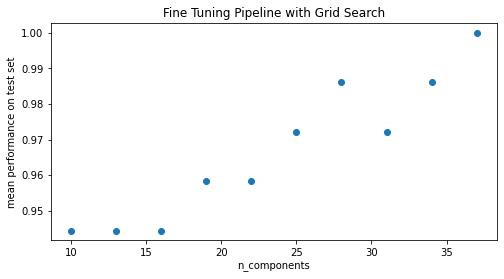

In [29]:
# Capture the result of the grid search as a dataframe
results = pd.DataFrame(cv.cv_results_)
results.sort_values(by="mean_test_score", inplace=True)  # sort it by average performance on test set

# Plot the results
fig, ax = plt.subplots(figsize=[8, 4])
ax.scatter(x=results["param_pca__n_components"], y=results["mean_test_score"])
ax.set_xlabel("n_components")
ax.set_ylabel("mean performance on test set")
ax.set_title("Fine Tuning Pipeline with Grid Search")